# <span style='background:Yellow'> Bottom Temp & Salt difference between SOSE and WOA

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.29.9:44641")
client

Client Scheduler: tcp://10.32.29.9:44641 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
import geopandas
import scipy
import xesmf as xe

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
xr.set_options(display_style='text')

In [4]:
woa8110_pt = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_8110.nc')
woa8110_slt = xr.open_dataset('/home/jovyan/WMT/WOA/san_bottom_wg_8110.nc')

woa0517_pt = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_0517.nc')
woa0517_slt = xr.open_dataset('/home/jovyan/WMT/WOA/san_bottom_wg_0517.nc')

sose_temp = xr.open_dataset('/home/jovyan/WMT/SOSE-budgets/bottom_temp.nc')
sose_slt = xr.open_dataset('/home/jovyan/WMT/SOSE-budgets/bottom_slt.nc')

surface_mask_sose = xr.open_dataset('/home/jovyan/WMT/SOSE-budgets/surface_mask.nc')

# <span style='background:Pink'> <font color='Red'> Temperature </font>

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp data onto SOSE's finer grid

In [5]:
regridder = xe.Regridder(woa8110_pt, sose_temp, method='bilinear')
regridder

Overwrite existing file: bilinear_19x96_95x570.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_19x96_95x570.nc 
Reuse pre-computed weights? False 
Input grid shape:           (19, 96) 
Output grid shape:          (95, 570) 
Output grid dimension name: ('YC', 'XC') 
Periodic in longitude?      False

In [6]:
woa8110_pt_new_grid = regridder(woa8110_pt)
woa8110_pt_new_grid

using dimensions ('lat', 'lon') from data variable PT as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (XC: 570, YC: 95, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
    lat      (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
Dimensions without coordinates: XC, YC
Data variables:
    PT       (time, YC, XC) float64 0.0 0.0 0.0 nan ... -0.6926 -0.6907 -0.6888
Attributes:
    regrid_method:  bilinear

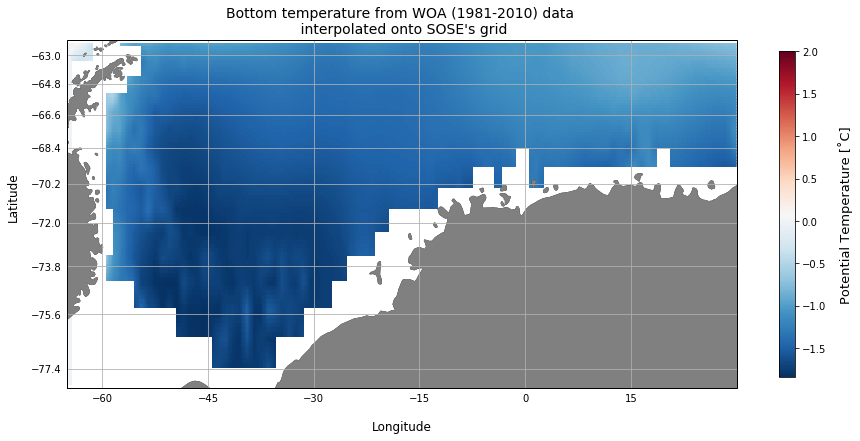

In [7]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(woa8110_pt_new_grid.lon, 
                   woa8110_pt_new_grid.lat, 
                   woa8110_pt_new_grid.PT[0], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Bottom temperature from WOA (1981-2010) data \n interpolated onto SOSE's grid", fontsize=14);

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `SOSE - WOA` (1981-2010) </font>

In [8]:
sose_woa8110_diff = sose_temp.THETA - woa8110_pt_new_grid.isel(time=0).PT
sose_woa8110_diff

<xarray.DataArray (YC: 95, XC: 570)>
array([[0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       ...,
       [0.59500206, 0.59372324, 0.58602089, ..., 0.13827111, 0.1367764 ,
        0.1352197 ],
       [0.71324372, 0.71202612, 0.7027545 , ..., 0.12470889, 0.12285769,
        0.12160721],
       [0.8445248 , 0.83526862, 0.81865788, ..., 0.11415889, 0.11163954,
        0.11010068]])
Coordinates:
  * YC       (YC) float64 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float64 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    Z        (YC, XC) float32 ...
    lat      (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
    lon      (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
    time     datetime64[ns] 2000-01-15

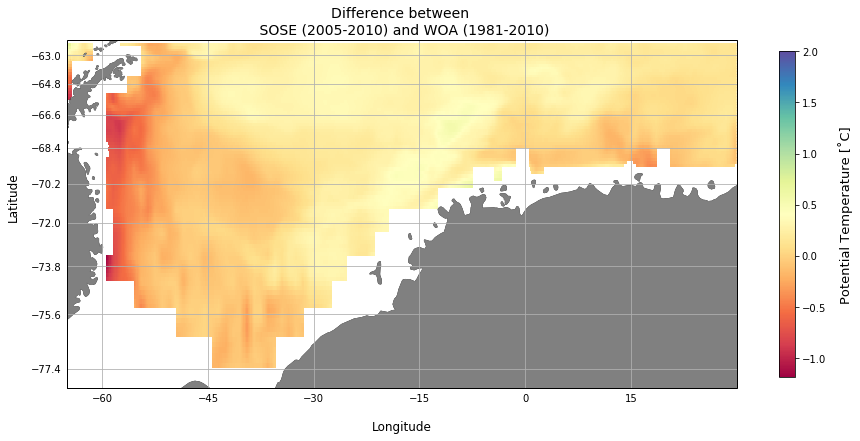

In [40]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(sose_woa8110_diff.lon, 
                   sose_woa8110_diff.lat, 
                   sose_woa8110_diff.where(surface_mask_sose.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='Spectral', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SOSE (2005-2010) and WOA (1981-2010)", fontsize=14);

### <span style='color:Brown'> Interpolating WOA (2005-2017) temp data onto SOSE's finer grid

In [11]:
regridder_2 = xe.Regridder(woa0517_pt, sose_temp, method='bilinear')
regridder_2

Overwrite existing file: bilinear_19x96_95x570.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_19x96_95x570.nc 
Reuse pre-computed weights? False 
Input grid shape:           (19, 96) 
Output grid shape:          (95, 570) 
Output grid dimension name: ('YC', 'XC') 
Periodic in longitude?      False

In [12]:
woa0517_pt_new_grid = regridder_2(woa0517_pt)
woa0517_pt_new_grid

using dimensions ('lat', 'lon') from data variable PT as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (XC: 570, YC: 95, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
    lat      (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
Dimensions without coordinates: XC, YC
Data variables:
    PT       (time, YC, XC) float64 0.0 0.0 0.0 nan ... -0.7994 -0.7961 -0.7928
Attributes:
    regrid_method:  bilinear

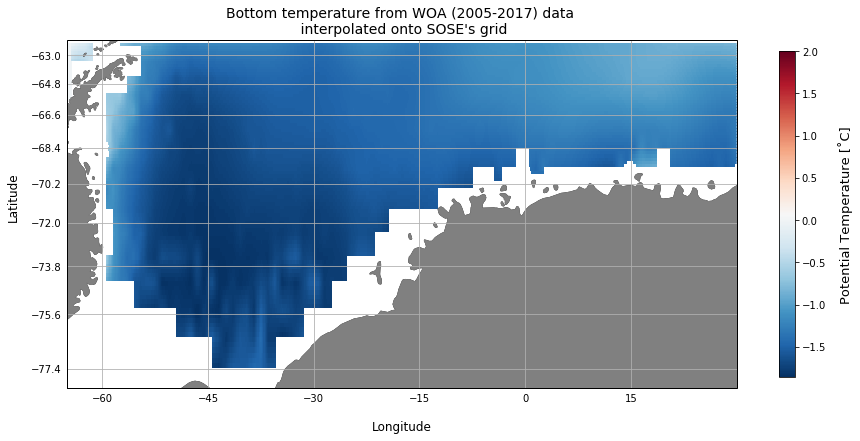

In [13]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(woa0517_pt_new_grid.lon, 
                   woa0517_pt_new_grid.lat, 
                   woa0517_pt_new_grid.PT[0].where(surface_mask_sose.hFacC), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Bottom temperature from WOA (2005-2017) data \n interpolated onto SOSE's grid", fontsize=14);

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `SOSE - WOA` (2005-2017) </font>

In [16]:
sose_woa0517_diff = sose_temp.THETA - woa0517_pt_new_grid.isel(time=0).PT
sose_woa0517_diff

<xarray.DataArray (YC: 95, XC: 570)>
array([[0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       ...,
       [0.59500206, 0.59372324, 0.58602089, ..., 0.24476289, 0.24195915,
        0.23909209],
       [0.71324372, 0.71202612, 0.7027545 , ..., 0.23149454, 0.22827407,
        0.22565413],
       [0.8445248 , 0.83526862, 0.81865788, ..., 0.22101953, 0.21708091,
        0.21412259]])
Coordinates:
  * YC       (YC) float64 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float64 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    Z        (YC, XC) float32 ...
    lat      (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
    lon      (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
    time     datetime64[ns] 2000-01-15

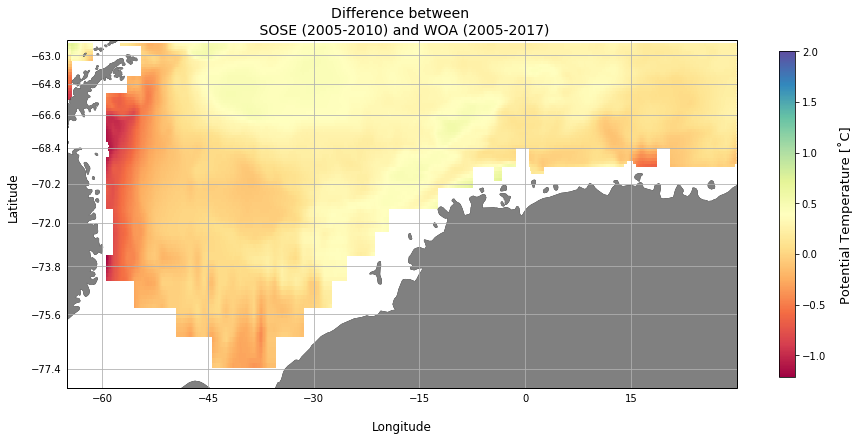

In [41]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(sose_woa0517_diff.lon, 
                   sose_woa0517_diff.lat, 
                   sose_woa0517_diff.where(surface_mask_sose.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='Spectral', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SOSE (2005-2010) and WOA (2005-2017)", fontsize=14);

# <span style='background:Pink'> <font color='Red'> Salinity </font>

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt data onto ECCO's grid

In [18]:
sose_slt

<xarray.Dataset>
Dimensions:  (XC: 570, YC: 95)
Coordinates:
    Z        (YC, XC) float32 ...
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
    lat      (YC) float32 ...
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
    lon      (XC) float32 ...
Data variables:
    SALT     (YC, XC) float32 ...

In [19]:
woa8110_slt

<xarray.Dataset>
Dimensions:  (lat: 19, lon: 96, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lev      (time, lat, lon) float64 ...
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -64.5 -63.5 -62.5 -61.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Data variables:
    san      (time, lat, lon) float32 ...

In [20]:
regridder_slt = xe.Regridder(woa8110_slt, sose_slt, method='bilinear')
regridder_slt

Overwrite existing file: bilinear_19x96_95x570.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_19x96_95x570.nc 
Reuse pre-computed weights? False 
Input grid shape:           (19, 96) 
Output grid shape:          (95, 570) 
Output grid dimension name: ('YC', 'XC') 
Periodic in longitude?      False

In [21]:
woa8110_slt_new_grid = regridder_slt(woa8110_slt)
woa8110_slt_new_grid

using dimensions ('lat', 'lon') from data variable san as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (XC: 570, YC: 95, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
    lat      (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
Dimensions without coordinates: XC, YC
Data variables:
    san      (time, YC, XC) float64 0.0 0.0 0.0 nan ... 34.65 34.65 34.65 34.65
Attributes:
    regrid_method:  bilinear

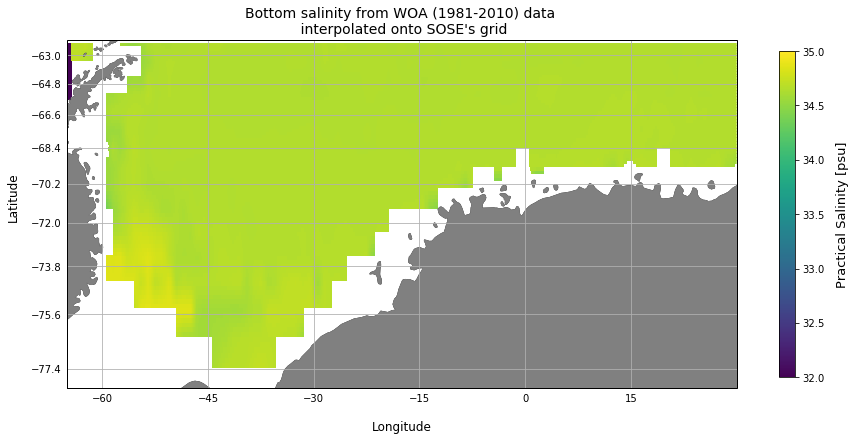

In [22]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(woa8110_slt_new_grid.lon, 
                   woa8110_slt_new_grid.lat, 
                   woa8110_slt_new_grid.san[0].where(surface_mask_sose.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='viridis', vmin=32, vmax=35)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Bottom salinity from WOA (1981-2010) data \n interpolated onto SOSE's grid", fontsize=14);

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `ECCO - WOA` (1981-2010) </font>

In [63]:
#checking if nans
print(np.isnan(sose_slt.SALT.sum()))

<xarray.DataArray 'SALT' ()>
array(False)


In [23]:
sose_woa8110_slt_diff = sose_slt.SALT - woa8110_slt_new_grid.isel(time=0).san
sose_woa8110_slt_diff

<xarray.DataArray (YC: 95, XC: 570)>
array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       ...,
       [33.70853806, 33.70941544, 33.70952225, ..., -0.79683421,
        -0.79504549, -0.79348203],
       [33.72277069, 33.72353745, 33.72320938, ..., -0.79393856,
        -0.7928902 , -0.79192567],
       [33.74181747, 33.74131012, 33.73955536, ..., -0.79092479,
        -0.79069754, -0.79024896]])
Coordinates:
  * YC       (YC) float64 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float64 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    Z        (YC, XC) float32 ...
    lat      (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
    lon      (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
    time     datetime64[ns] 2000-01-15

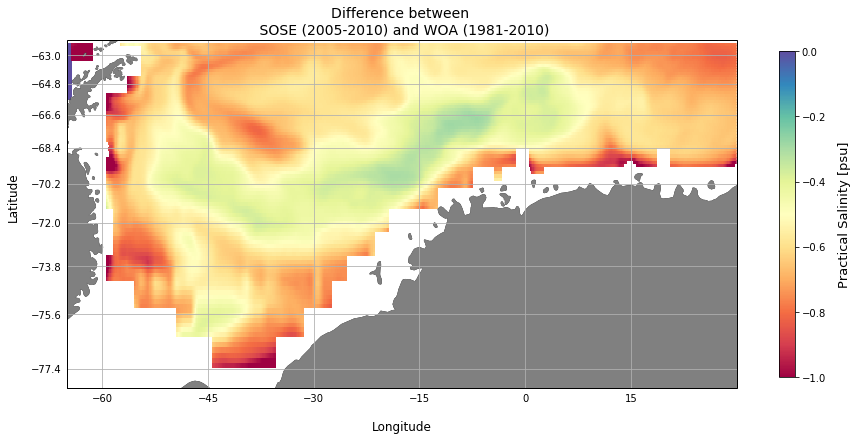

In [34]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(sose_woa8110_slt_diff.lon, 
                   sose_woa8110_slt_diff.lat, 
                   sose_woa8110_slt_diff.where(surface_mask_sose.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='Spectral', vmax=0, vmin=-1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SOSE (2005-2010) and WOA (1981-2010)", fontsize=14);

### <span style='color:Brown'> Interpolating WOA (2005-2017) salt data onto SOSE's grid

In [25]:
regridder_2_slt = xe.Regridder(woa0517_slt, sose_slt, method='bilinear')
regridder_2_slt

Overwrite existing file: bilinear_19x96_95x570.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_19x96_95x570.nc 
Reuse pre-computed weights? False 
Input grid shape:           (19, 96) 
Output grid shape:          (95, 570) 
Output grid dimension name: ('YC', 'XC') 
Periodic in longitude?      False

In [26]:
woa0517_slt_new_grid = regridder_2_slt(woa0517_slt)
woa0517_slt_new_grid

using dimensions ('lat', 'lon') from data variable san as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (XC: 570, YC: 95, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
    lat      (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
Dimensions without coordinates: XC, YC
Data variables:
    san      (time, YC, XC) float64 0.0 0.0 0.0 nan ... 34.65 34.65 34.65 34.65
Attributes:
    regrid_method:  bilinear

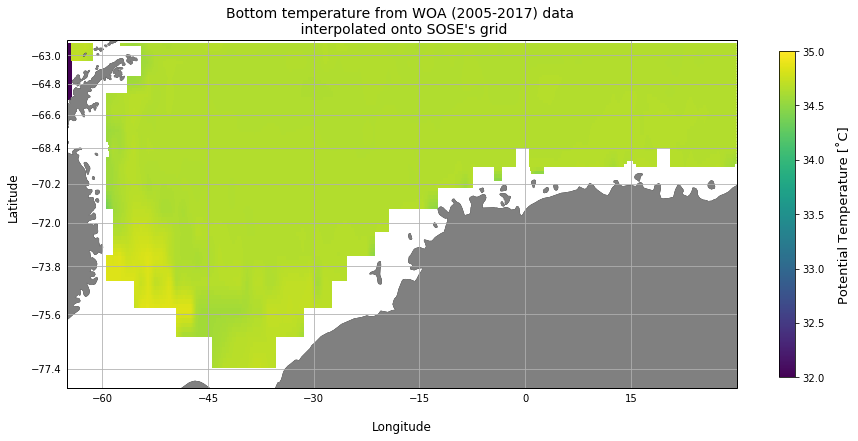

In [27]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(woa0517_slt_new_grid.lon, 
                   woa0517_slt_new_grid.lat, 
                   woa0517_slt_new_grid.san[0].where(surface_mask_sose.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='viridis', vmin=32, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Bottom temperature from WOA (2005-2017) data \n interpolated onto SOSE's grid", fontsize=14);

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `SOSE - WOA` (2005-2017) </font>

In [28]:
sose_woa0517_slt_diff = sose_slt.SALT - woa0517_slt_new_grid.isel(time=0).san
sose_woa0517_slt_diff

<xarray.DataArray (YC: 95, XC: 570)>
array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       ...,
       [33.70853806, 33.70941544, 33.70952225, ..., -0.79658372,
        -0.79482244, -0.79328647],
       [33.72277069, 33.72353745, 33.72320938, ..., -0.79366666,
        -0.79264958, -0.79171637],
       [33.74181747, 33.74131012, 33.73955536, ..., -0.7906371 ,
        -0.79044389, -0.79002937]])
Coordinates:
  * YC       (YC) float64 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float64 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    Z        (YC, XC) float32 ...
    lat      (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
    lon      (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
    time     datetime64[ns] 2000-01-15

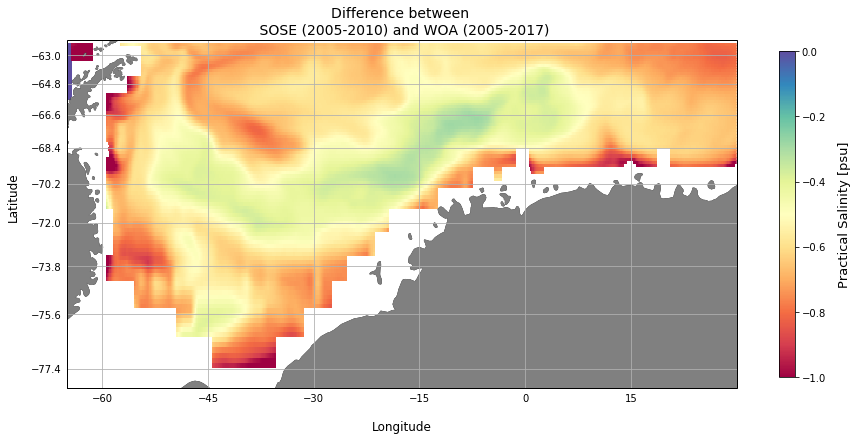

In [35]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(sose_woa0517_slt_diff.lon, 
                   sose_woa0517_slt_diff.lat, 
                   sose_woa0517_slt_diff.where(surface_mask_sose.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='Spectral', vmin=-1, vmax=0)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SOSE (2005-2010) and WOA (2005-2017)", fontsize=14);